# TASK-1: Exploratory Data Analysis (EDA)


## 1. 
Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data?

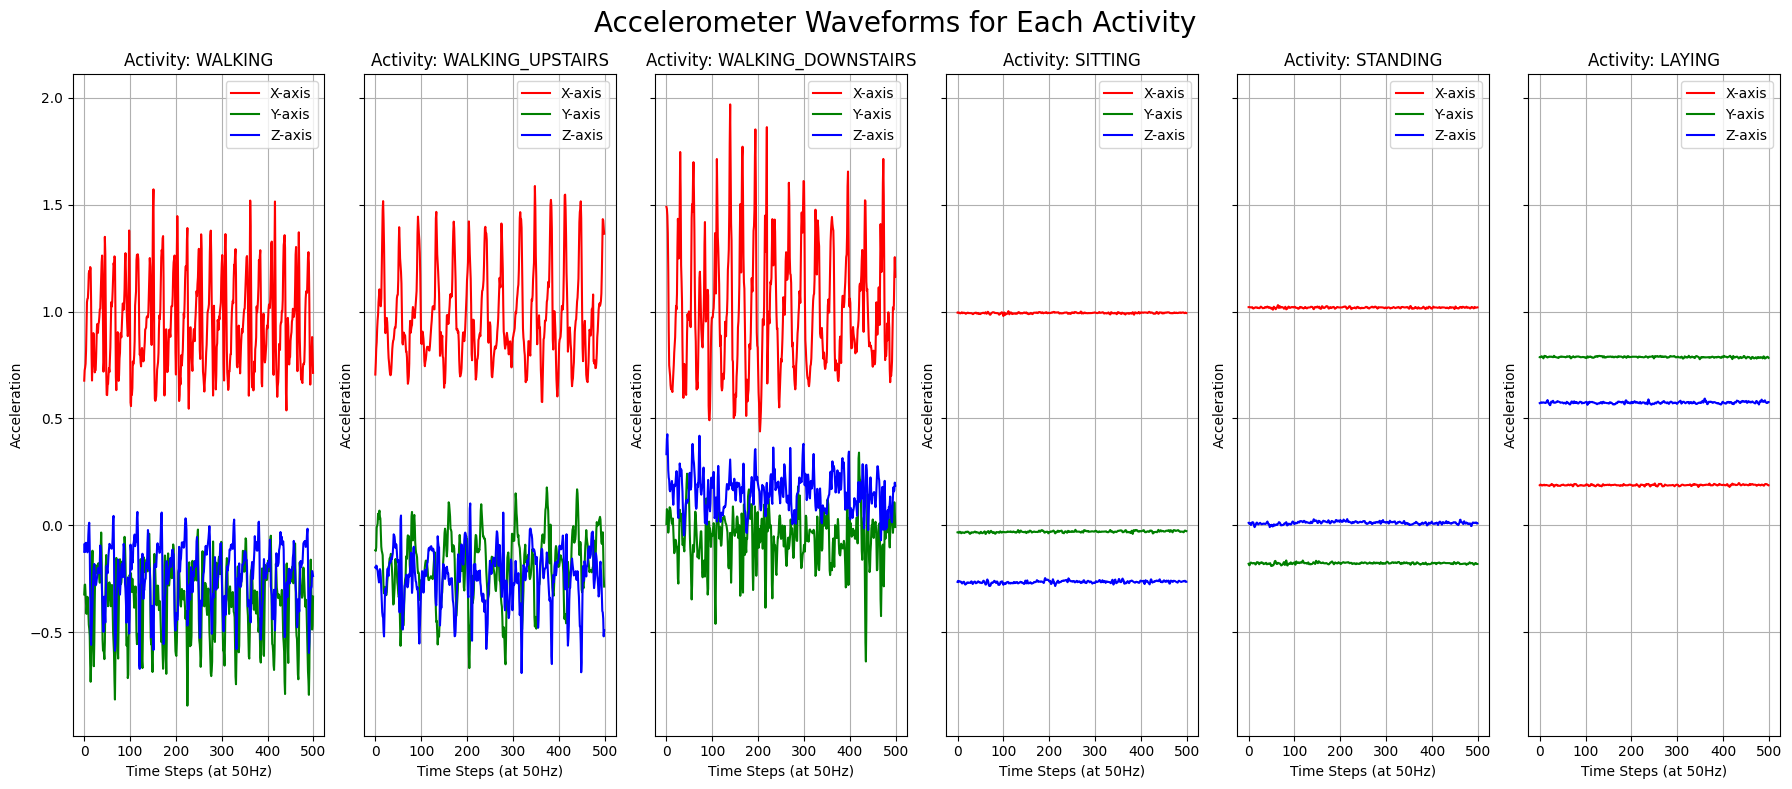

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
X_train = np.load('Dataset/X_train.npy')  
y_train = np.load('Dataset/y_train.npy') 

# creating a dictionary to store key:value pairs.
activity = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}


sample = {}  
for act in activity.keys():    
    index = np.where(y_train == act)[0][0]
    sample[act] = index    #finds the index

fig, axs = plt.subplots(1, 6, figsize=(18, 8), sharey=True) #1 row and 6 columns. SHarey=True for easy comparison so y axis is same for all. axs--> array of 6 empty plots

#one sample for each activity
for i, act in enumerate(activity.keys()): 
    ax = axs[i]     
    sample_index = sample[act]  
    sample_data = X_train[sample_index] # Shape: (500, 3)   
    
    # Plot X, Y, and Z axes
    ax.plot(sample_data[:, 0], label='X-axis', color='red')
    ax.plot(sample_data[:, 1], label='Y-axis', color='green')
    ax.plot(sample_data[:, 2], label='Z-axis', color='blue')
    
    ax.set_title(f'Activity: {activity[act]}', fontsize=12)
    ax.set_xlabel('Time Steps (at 50Hz)')
    ax.set_ylabel('Acceleration')
    ax.legend()
    ax.grid(True)

plt.suptitle('Accelerometer Waveforms for Each Activity', fontsize=20)
plt.tight_layout() 
plt.show()

By observing the plots, we can see similarities/differences between different activities.

Similarities:

Laying, Sitting, and Standing look almost the same. Their waveforms are flat with low amplitude, indicating minimum amount of movement.

Walking, Walking Upstairs, and Walking Downstairs are also similar to each other. They all have high amplitude, show periodic patterns, which correspond to repeated steps during walking.

Differences:

Among the activities- Laying, Sitting, and Standing, the main difference comes from the distribution of gravitational force across the three axes. In Laying, gravity is spread more across the Y axis, while in Sitting and Standing, it is mostly along the X axis. The exact values can change depending on the phone's orientation.

While all walking, walking upstairs, and walking downstairs show a walking pattern, there are differences in the amplitude and frequency. 

Yes, I think the model will be able to classify the activities based on the data. The differences between the activities are prominent enough for a machine learning model to learn distinguishing features. 

## 2.
 Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $a_x^2+a_y^2+a_z^2$ for each activity and justify your answer.

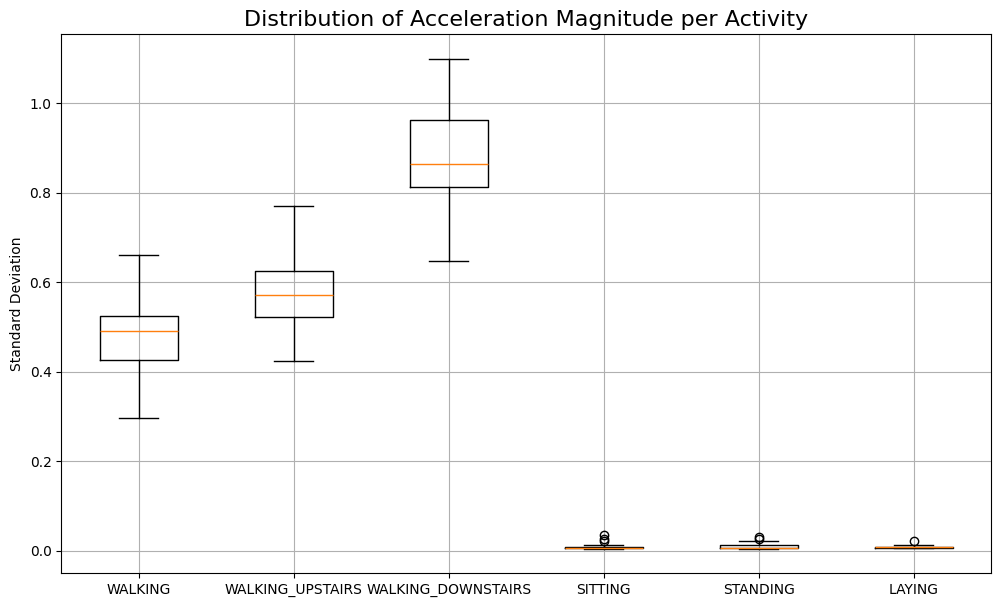

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
X_train = np.load('Dataset/X_train.npy')
y_train = np.load('Dataset/y_train.npy')
X_val = np.load('Dataset/X_val.npy')
y_val = np.load('Dataset/y_val.npy')
  
X_data = np.concatenate((X_train, X_val), axis=0)  #X_data(126,500,3), y_data(54,500,3), concatenate(126+54, 500,3)
y_data = np.concatenate((y_train, y_val), axis=0)


activity = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING", 
    5: "STANDING",
      6: "LAYING"
}

# Calculate the standard deviation of the acceleration magnitude for each sample
results = [] 

for i in range(X_data.shape[0]): 
    sample = X_data[i]   #shape of sample --> (500,3)
    magnitude = (np.sum(sample**2, axis=1))
    std_dev = np.std(magnitude)
    
    results.append((activity[y_data[i]], std_dev))

#  It converts our results list into a Pandas DataFrame.
df = pd.DataFrame(results, columns=['Activity', 'Magnitude_StdDev'])


plot_data = []  #contains all std for each activity
activity_labels = []

# Order the activities as they appear in activity
activities = list(activity.values())

for activity in activities:  #loop through each actvity name
    # Get all the std_dev values for the current activity
    activity_data = df[df['Activity'] == activity]['Magnitude_StdDev'].values  #creates a filter selecting only rows where "Activity" matches the current activity.
    plot_data.append(activity_data)
    activity_labels.append(activity)

plt.figure(figsize=(12, 7))
plt.boxplot(plot_data) 
plt.title('Distribution of Acceleration Magnitude per Activity', fontsize=16)
plt.ylabel('Standard Deviation')
plt.xticks(ticks=np.arange(1, len(activity_labels) + 1), labels=activity_labels)
plt.grid(True)
plt.show()

We do not think that we need an ML model to differentiate between static and dynamic activities. 
The standard deviation for static activities- sitting, walking and laying are very close to 0 and for dynamic activities- walking, walking upstairs and walking downstairs, SD is much higher around 0.25-0.35. 
So we can see that there is a large difference between the the two type of activities and we can easily define a threshold. For example-
\
if std_dev < 0.2:
\
    activity = "Static"
\
else:\
    activity = "Dynamic"

if-else statement is enough for this specific task and do not need a complex ML model.
However, to differentiate among activities within the same group (e.g., sitting vs standing, or walking vs walking upstairs), we would need a machine learning model because their signals are more similar.

###  3.
 (a) Use PCA (Principal Component Analysis) on Total Acceleration  $a_x^2+a_y^2+a_z^2$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities.

In [26]:
# common for all 3parts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tsfel



# This line takes all the data for one activity, assigns it a color and a name, and plots it in the correct position on our graph. The loop repeats this for all six activities.
# Function to create a scatter plot for PCA results
def plot_pca(pca_result, labels, title):  #pca_result--> the 2d data, labels-->1-6  (reusable function which can be used 3 times for all 3 questions)
    plt.figure(figsize=(10, 8))
    # Define colors for the 6 activities
    unique_labels = sorted(np.unique(labels)) #sorted-->order and unique-->one number to each
    colors = plt.cm.get_cmap('jet', len(unique_labels))   #matplot's function to get a color map
    
    for i, label in enumerate(unique_labels):
        # Find indices for each activity label
        idx = np.where(labels == label)  #(for every no inside loop, it holds inidices for current activity i.e if label is 1"walking", it will hold the indices of all wlaking sample )
        plt.scatter(pca_result[idx, 0], pca_result[idx, 1], color=colors(i), label=activity[label], alpha=0.7) #alpha if overlapping, it will allow us to see.
        #for all pca_results data, it will take all rows specified by idx for each column one by one)-0-->x axis (pc1), 1-->y (PC2)

    plt.title(title, fontsize=16)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()



X_train = np.load('Dataset/X_train.npy')
y_train = np.load('Dataset/y_train.npy')
X_val = np.load('Dataset/X_val.npy')
y_val = np.load('Dataset/y_val.npy')
X_data = np.concatenate((X_train, X_val), axis=0)
y_data = np.concatenate((y_train, y_val), axis=0)


activity = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING", 
    6: "LAYING"
}


PCA on Total Acceleration to compress the acceleration timeseries


C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\4018600526.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('jet', len(unique_labels))   #matplot's function to get a color map


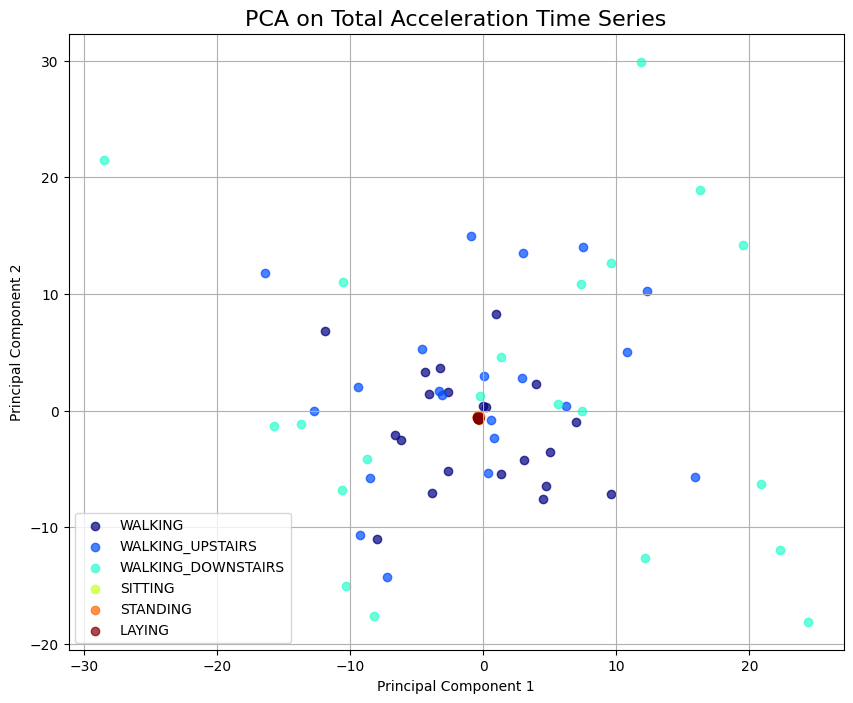

In [27]:
# 1. PCA ON TOTAL ACCELERATION TIME SERIES
print("PCA on Total Acceleration to compress the acceleration timeseries")

total_acc = (np.sum(X_data**2, axis=2))
# Standardize the data before PCA
scaler = StandardScaler()  # This step standardizes each of the 500 feature columns to have a mean of 0 and a standard deviation of 1.
magnitude_scaled = scaler.fit_transform(total_acc)

# Apply PCA
pca = PCA(n_components=2) 
pca_results = pca.fit_transform(magnitude_scaled) 
# shape of pca_results-->(sample,2)
plot_pca(pca_results, y_data, 'PCA on Total Acceleration Time Series')

### (b)
 Next, use TSFEL (a featurizer library) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\2285143058.py:12: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, single_series, verbose=0)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\2285143058.py:12: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, single_series, verbose=0)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\2285143058.py:12: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, single_series, verbose=0)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\2285143058.py:12: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, single_series, verbose=0)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\2285143058.py:12: UserWarning: Using default sampling frequenc

TSFEL feature extraction complete. Feature matrix shape: (126, 31)


C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\4018600526.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('jet', len(unique_labels))   #matplot's function to get a color map


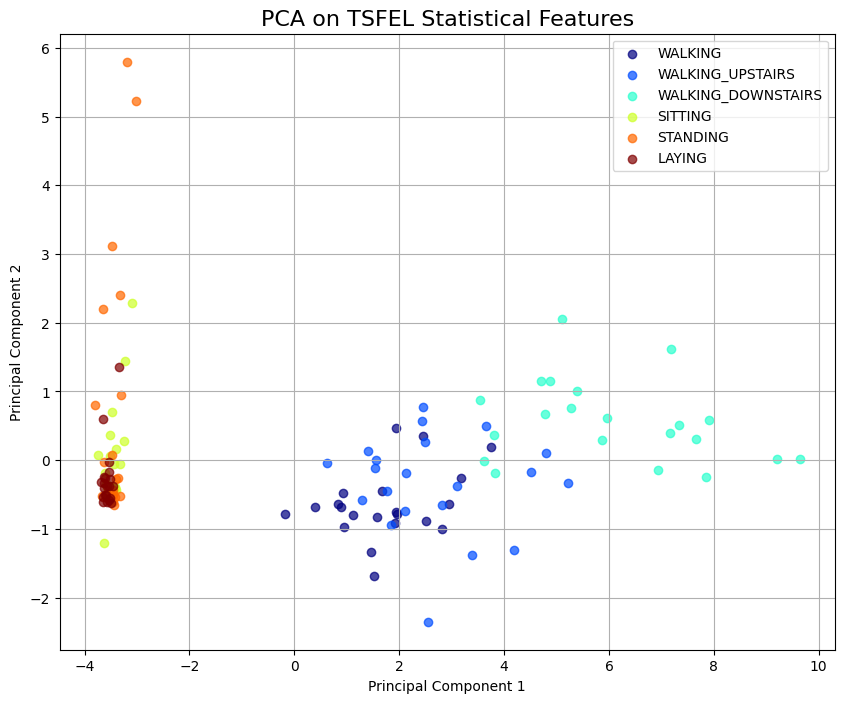

In [28]:
# --- 2. PCA ON TSFEL FEATURES ---
#  Retrieves a pre-defined feature configuration file to extract the temporal, statistical and spectral feature sets...here only statistical
cfg = tsfel.get_features_by_domain('statistical')

all_features_list = []

# Loop through each sample
for i in range(total_acc.shape[0]):
    # Get a single time series (one sample)
    single_series = total_acc[i, :]
    # Extract features for this single series
    features = tsfel.time_series_features_extractor(cfg, single_series, verbose=0)
    all_features_list.append(features)

# Concatenate all the results into a single DataFrame
tsfel_features = pd.concat(all_features_list).reset_index(drop=True)

print("TSFEL feature extraction complete. Feature matrix shape:", tsfel_features.shape)

# Standardize and apply PCA
scaler_tsfel = StandardScaler()
tsfel_scaled = scaler_tsfel.fit_transform(tsfel_features)
pca_tsfel = PCA(n_components=2)
pca_result_tsfel = pca_tsfel.fit_transform(tsfel_scaled)  #shape(samples,2)
plot_pca(pca_result_tsfel, y_data, 'PCA on TSFEL Statistical Features')


### (c) 
Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\3873560046.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_orig = pd.read_csv('UCI HAR Dataset/'+ 'train/X_train.txt', delim_whitespace=True, header=None)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\3873560046.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_orig = pd.read_csv('UCI HAR Dataset/' + 'test/X_test.txt', delim_whitespace=True, header=None)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\4018600526.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('jet', len(unique_labels))   #matplot's function to get

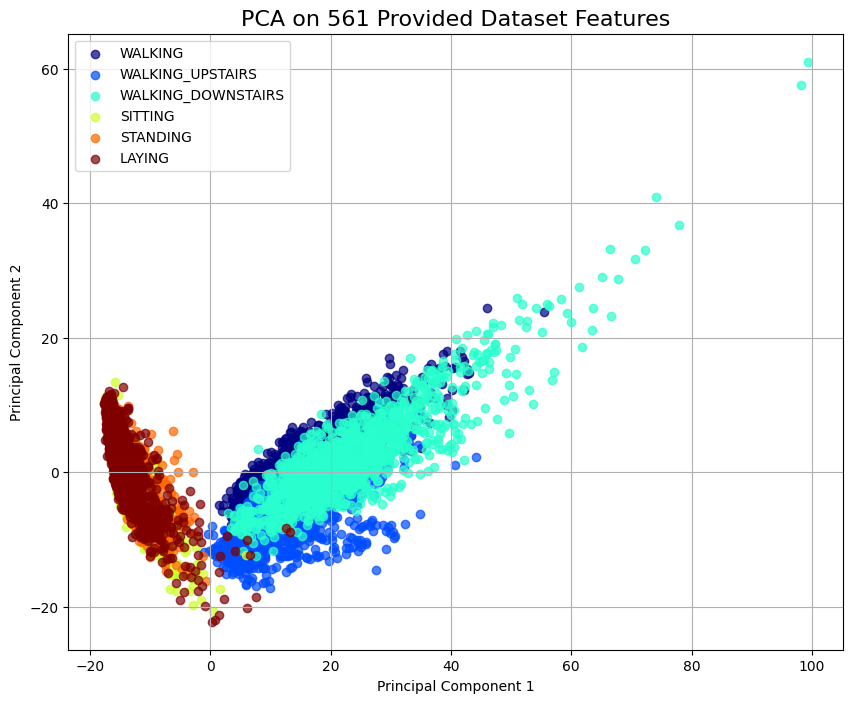

In [29]:
# --- 3. PCA ON PROVIDED DATASET FEATURES ---

# This step requires the original files from the UCI HAR Dataset folder.
X_train_orig = pd.read_csv('UCI HAR Dataset/'+ 'train/X_train.txt', delim_whitespace=True, header=None)
X_test_orig = pd.read_csv('UCI HAR Dataset/' + 'test/X_test.txt', delim_whitespace=True, header=None)
y_train_orig = pd.read_csv('UCI HAR Dataset/' + 'train/y_train.txt', header=None)
y_test_orig = pd.read_csv('UCI HAR Dataset/' + 'test/y_test.txt', header=None)
    

X_orig = pd.concat([X_train_orig, X_test_orig])
y_orig = pd.concat([y_train_orig, y_test_orig]).values.flatten() # Flatten to 1D array

# Standardize and apply PCA
scaler_orig = StandardScaler()
X_orig_scaled = scaler_orig.fit_transform(X_orig)
pca_orig = PCA(n_components=2)
pca_result_orig = pca_orig.fit_transform(X_orig_scaled)
plot_pca(pca_result_orig, y_orig, 'PCA on 561 Provided Dataset Features')

### (c)
 Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data?


\
(i) PCA on Total Acceleration- We see from the plot that the static activities form a cluster in the middle while dynamic activities are spread out. 
\
Advantages- It separates static from dynamic activities.
\
Disadvantage- It does not separate individual activities from each other. The three static activities completely overlap and hence, indistinguishable.
\
(ii) PCA on TSFEL- We see that this graph is clearer than the one obtained using PCA in total acceleration.
\
Advantages- Though still clustered, static activities begin to separate from each other. Laying separates from sitting and standing.
\
Disadvantages- There is still overlap between similar activities, especially sitting and standing.
\
(iii) PCA on Dataset features- This is the best of the three results. All 6 activities form their own separate clusters. (which is also an advantage)
\
Disadvantage- An overlap between sitting and standing is still there, confirming that these two activities are the very similar and the hard to distinguish.
\
Conclusion- PCA on Dataset features is better for visualizing the data.

## 4.
 Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features?

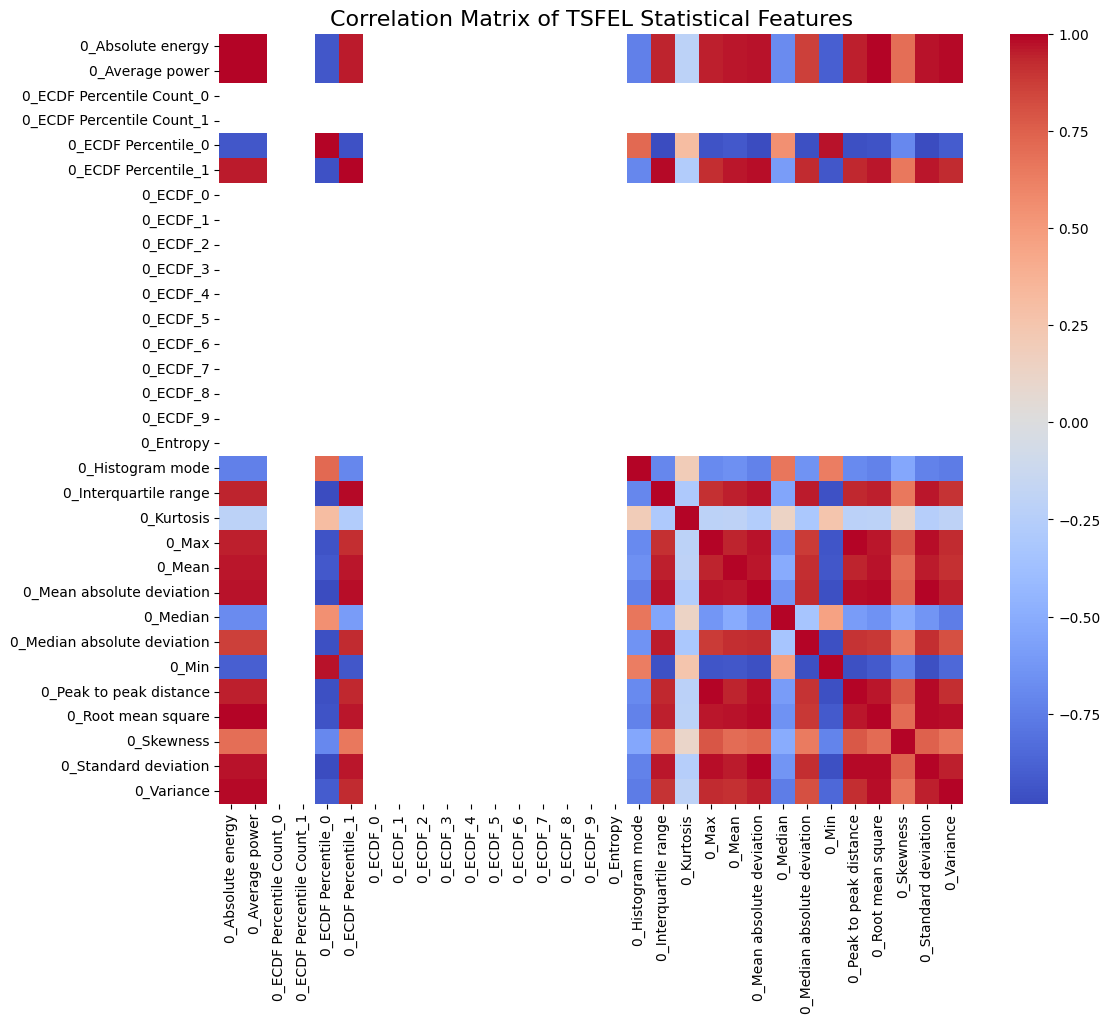

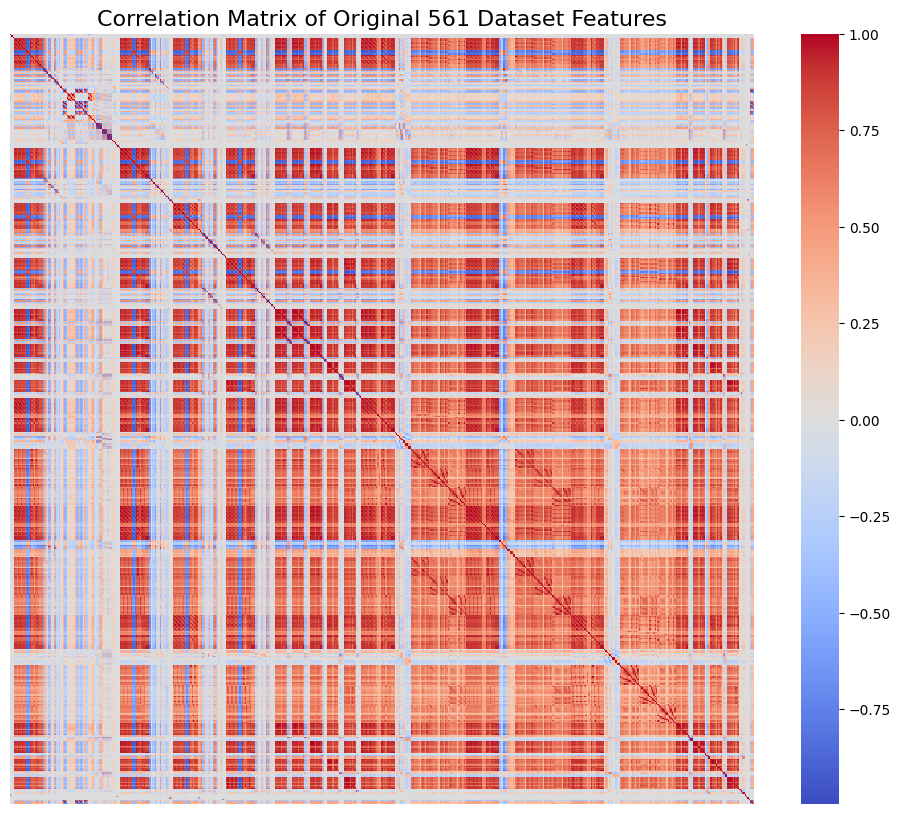

In [30]:
import seaborn as sns

#1. Correlation for TSFEL Features
tsfel_corr = tsfel_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(tsfel_corr, cmap='coolwarm')
plt.title('Correlation Matrix of TSFEL Statistical Features', fontsize=16)
plt.show()


#2. Correlation for Original 561 Features
if X_orig is not None:
    orig_corr = X_orig.corr()
    plt.figure(figsize=(12, 10))
    # We don't show labels (xticklabels, yticklabels) because 561 labels are unreadable
    sns.heatmap(orig_corr, cmap='coolwarm', xticklabels=False, yticklabels=False)
    plt.title('Correlation Matrix of Original 561 Dataset Features', fontsize=16)
    plt.show()

The features that are highly correlated with each other are:
1. Standard deviation and variance
2. mean and median
3. max and min
\
Yes, all these pairs are redundant features since they provide the same information.

# TASK-2 (1)
 Use Sklearn Library to train Decision Tress.

## 
1. Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.
2. Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model.
3. Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model.



1: Raw Accelerometer Data...
Accuracy: 0.6481
Report:
                    precision    recall  f1-score   support

           WALKING       0.36      0.56      0.43         9
  WALKING_UPSTAIRS       0.67      0.44      0.53         9
WALKING_DOWNSTAIRS       0.50      0.33      0.40         9
           SITTING       0.89      0.89      0.89         9
          STANDING       0.67      0.67      0.67         9
            LAYING       0.90      1.00      0.95         9

          accuracy                           0.65        54
         macro avg       0.66      0.65      0.65        54
      weighted avg       0.66      0.65      0.65        54



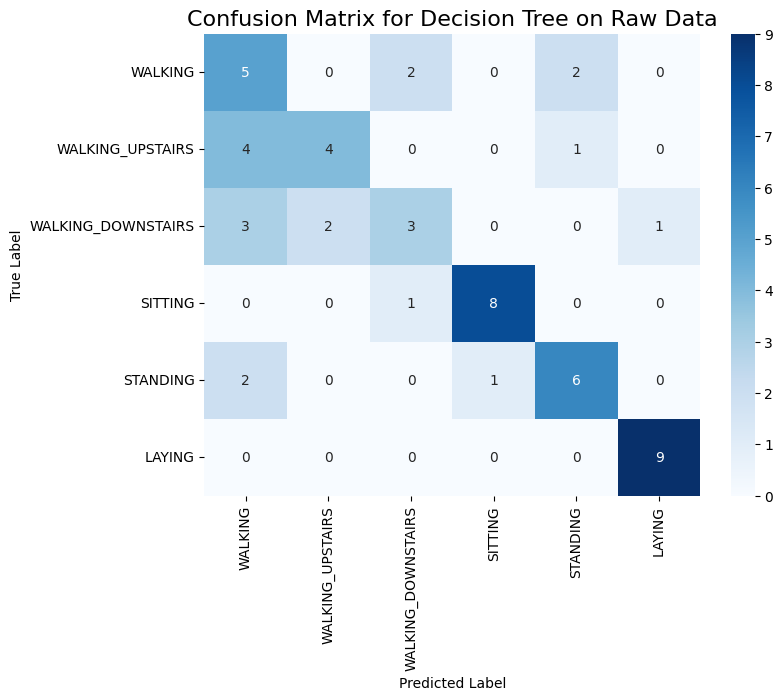

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tsfel

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def model(y_true, y_pred, model_name):
    
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=activity.values())
    
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Report:")
    print(report)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=activity.values(), yticklabels=activity.values())
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

activity = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING", 
    5: "STANDING",
    6: "LAYING"
}


# 1: Using Raw Accelerometer Data

print("1: Raw Accelerometer Data...")

X_train_raw = np.load('Dataset/X_train.npy')
y_train = np.load('Dataset/y_train.npy')
X_test_raw = np.load('Dataset/X_test.npy')
y_test = np.load('Dataset/y_test.npy')

# Reshape the 3D data (samples, timesteps, axes) to 2D (samples, features)
# 500 timesteps * 3 axes = 1500 features
n_samples_train, n_timesteps, n_axes = X_train_raw.shape
n_samples_test = X_test_raw.shape[0]
X_train_flat = X_train_raw.reshape((n_samples_train, n_timesteps * n_axes))
X_test_flat = X_test_raw.reshape((n_samples_test, n_timesteps * n_axes))

# Train the Decision Tree
dt_raw = DecisionTreeClassifier(random_state=42)
dt_raw.fit(X_train_flat, y_train)
y_pred_raw = dt_raw.predict(X_test_flat)

model(y_test, y_pred_raw, "Decision Tree on Raw Data")



2: TSFEL Features


C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\583988522.py:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, single_series, verbose=0)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\583988522.py:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, single_series, verbose=0)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\583988522.py:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, single_series, verbose=0)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\583988522.py:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, single_series, verbose=0)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\583988522.py:10: UserWarning: Using default sampling frequency set

Accuracy: 0.7407
Report:
                    precision    recall  f1-score   support

           WALKING       0.86      0.67      0.75         9
  WALKING_UPSTAIRS       0.64      0.78      0.70         9
WALKING_DOWNSTAIRS       0.89      0.89      0.89         9
           SITTING       0.57      0.44      0.50         9
          STANDING       1.00      1.00      1.00         9
            LAYING       0.55      0.67      0.60         9

          accuracy                           0.74        54
         macro avg       0.75      0.74      0.74        54
      weighted avg       0.75      0.74      0.74        54



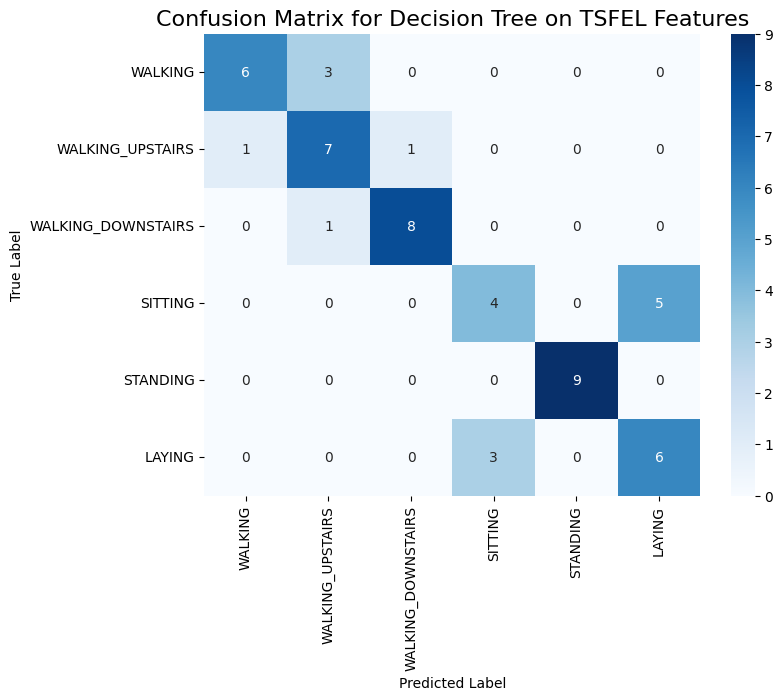

In [32]:
# 2: Using TSFEL Features

print("2: TSFEL Features")
def tsfel_features(X_data):
    acc = (np.sum(X_data**2, axis=2))
    cfg = tsfel.get_features_by_domain('statistical')
    all_features_list = []
    for i in range(acc.shape[0]):
        single_series = acc[i, :]
        features = tsfel.time_series_features_extractor(cfg, single_series, verbose=0)
        all_features_list.append(features)
    tsfel_features = pd.concat(all_features_list).reset_index(drop=True)
    return tsfel_features.fillna(0)

# Generate features for train and test sets separately
X_train_tsfel = tsfel_features(X_train_raw)
X_test_tsfel = tsfel_features(X_test_raw)

# Train the Decision Tree
dt_tsfel = DecisionTreeClassifier(random_state=42)
dt_tsfel.fit(X_train_tsfel, y_train)
y_pred_tsfel = dt_tsfel.predict(X_test_tsfel)

# Evaluate the model
model(y_test, y_pred_tsfel, "Decision Tree on TSFEL Features")



3: Original Provided Features


C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\1142448574.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_orig = pd.read_csv('UCI HAR Dataset/'+ 'train/X_train.txt', delim_whitespace=True, header=None)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\1142448574.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_orig = pd.read_csv('UCI HAR Dataset/' + 'test/X_test.txt', delim_whitespace=True, header=None)


Accuracy: 0.8622
Report:
                    precision    recall  f1-score   support

           WALKING       0.83      0.92      0.87       496
  WALKING_UPSTAIRS       0.83      0.78      0.80       471
WALKING_DOWNSTAIRS       0.89      0.83      0.86       420
           SITTING       0.83      0.76      0.80       491
          STANDING       0.80      0.86      0.83       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.86      2947
         macro avg       0.86      0.86      0.86      2947
      weighted avg       0.86      0.86      0.86      2947



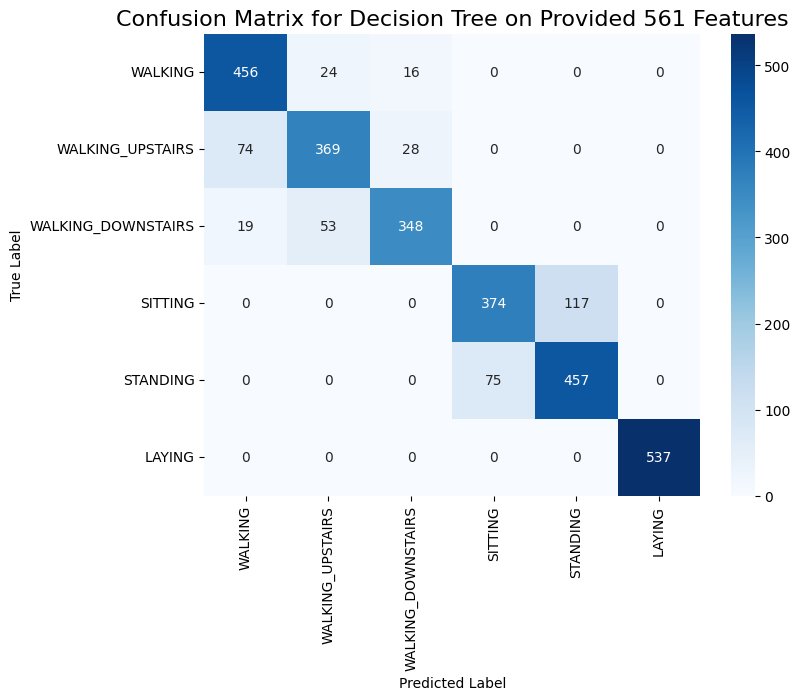

In [33]:
# 3: Using Provided Dataset Features

print("3: Original Provided Features")
 
X_train_orig = pd.read_csv('UCI HAR Dataset/'+ 'train/X_train.txt', delim_whitespace=True, header=None)
y_train_orig = pd.read_csv('UCI HAR Dataset/'+ 'train/y_train.txt', header=None).values.flatten()
X_test_orig = pd.read_csv('UCI HAR Dataset/' + 'test/X_test.txt', delim_whitespace=True, header=None)
y_test_orig = pd.read_csv('UCI HAR Dataset/' + 'test/y_test.txt', header=None).values.flatten()

# Train the Decision Tree
dt_orig = DecisionTreeClassifier(random_state=42)
dt_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = dt_orig.predict(X_test_orig)


model(y_test_orig, y_pred_orig, "Decision Tree on Provided 561 Features")


## (2) 
Compare the results of the three models. Which model do you think is better?

Comparison-
The model trained on the 561 Provided Dataset Features is the best.
\
It achieves the highest accuracy because its features are expertly engineered. The model with TSFEL features is a significant improvement over the raw data model, as its statistical features provide much more meaningful information than noisy, raw time-series data. This clearly shows that model performance is directly dependent on the quality of the input features.

## 2. 
Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree. 

C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\2423273514.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_orig = pd.read_csv(base_path + 'train/X_train.txt', delim_whitespace=True, header=None)
C:\Users\chesh\AppData\Local\Temp\ipykernel_32920\2423273514.py:41: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_orig = pd.read_csv(base_path + 'test/X_test.txt', delim_whitespace=True, header=None)


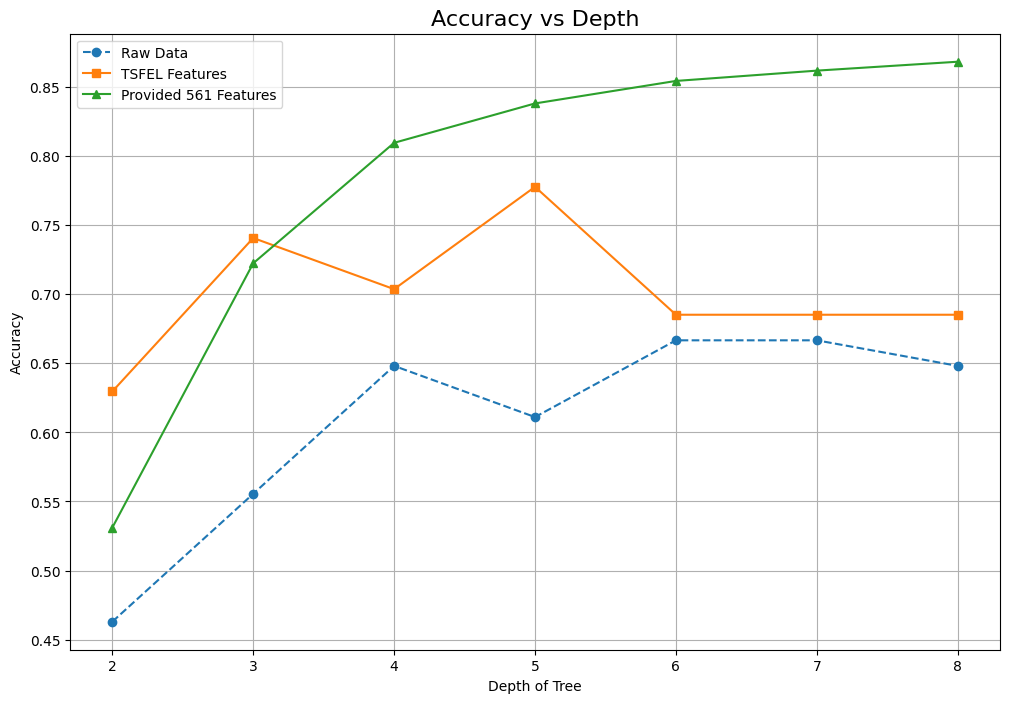

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tsfel

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train_raw = np.load('Dataset/X_train.npy')
y_train = np.load('Dataset/y_train.npy')
X_test_raw = np.load('Dataset/X_test.npy')
y_test = np.load('Dataset/y_test.npy')

n_samples_train, n_timesteps, n_axes = X_train_raw.shape
n_samples_test = X_test_raw.shape[0]
X_train_flat = X_train_raw.reshape((n_samples_train, n_timesteps * n_axes))
X_test_flat = X_test_raw.reshape((n_samples_test, n_timesteps * n_axes))


#2. Prepare TSFEL Features
def tsfel_features(X_data):
    total_acc = np.sqrt(np.sum(X_data**2, axis=2))
    cfg = tsfel.get_features_by_domain('statistical')
    all_features_list = []
    for i in range(total_acc.shape[0]):
        single_series =total_acc[i, :]
        features = tsfel.time_series_features_extractor(cfg, single_series, fs=50, verbose=0)
        all_features_list.append(features)
    tsfel_features = pd.concat(all_features_list).reset_index(drop=True)
    return tsfel_features.fillna(0)

X_train_tsfel = tsfel_features(X_train_raw)
X_test_tsfel = tsfel_features(X_test_raw)

#3. Original Provided Features
try:
    base_path = 'UCI HAR Dataset/'
    X_train_orig = pd.read_csv(base_path + 'train/X_train.txt', delim_whitespace=True, header=None)
    y_train_orig = pd.read_csv(base_path + 'train/y_train.txt', header=None).values.flatten()
    X_test_orig = pd.read_csv(base_path + 'test/X_test.txt', delim_whitespace=True, header=None)
    y_test_orig = pd.read_csv(base_path + 'test/y_test.txt', header=None).values.flatten()
except FileNotFoundError:
    print("Warning: Original dataset files not found.")
    X_train_orig = None # Set to None to handle gracefully

raw_accuracies = []
tsfel_accuracies = []
orig_accuracies = []
depths=[2,3,4,5,6,7,8]

for depth in [2,3,4,5,6,7,8]:
    # for Raw Data
    clf1 = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf1.fit(X_train_flat, y_train) 
    raw_accuracies.append(accuracy_score(y_test, clf1.predict(X_test_flat)))

    # for TSFEL Features
    clf2 = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf2.fit(X_train_tsfel, y_train)
    tsfel_accuracies.append(accuracy_score(y_test, clf2.predict(X_test_tsfel)))

    # for Original Features
    if X_train_orig is not None:
        clf3 = DecisionTreeClassifier( max_depth=depth, random_state=42)
        clf3.fit(X_train_orig, y_train_orig)
        orig_accuracies.append(accuracy_score(y_test_orig, clf3.predict(X_test_orig)))



plt.figure(figsize=(12, 8))
plt.plot(depths, raw_accuracies, marker='o', linestyle='--', label='Raw Data')
plt.plot(depths, tsfel_accuracies, marker='s', linestyle='-', label='TSFEL Features')
if X_train_orig is not None:
    plt.plot(depths, orig_accuracies, marker='^', linestyle='-', label='Provided 561 Features')

plt.title('Accuracy vs Depth', fontsize=16)
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()

## 3. 
Are there any participants/ activitivies where the Model performace is bad? If Yes, Why?

Yes, even with the best model, there are specific activities where performance is worse. There is a problem in distinguishing between standing and sitting.
This is because the accelerometer signal for both static activities are same. The model lacks distinct features to differentiate them, causing confusion. Performance can also be affected because it was trained on many people and does not generalize perfectly to specific movements.

Accuracy: 0.4000

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00         3
  WALKING_UPSTAIRS       0.33      1.00      0.50         3
WALKING_DOWNSTAIRS       0.00      0.00      0.00         3
           SITTING       0.75      1.00      0.86         3
          STANDING       0.00      0.00      0.00         2
            LAYING       0.00      0.00      0.00         1

          accuracy                           0.40        15
         macro avg       0.18      0.33      0.23        15
      weighted avg       0.22      0.40      0.27        15



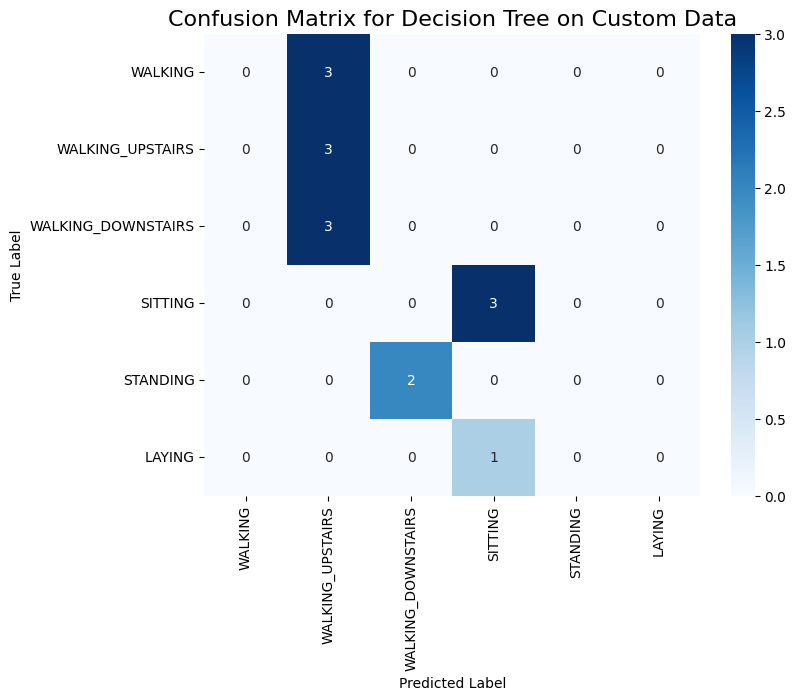

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tsfel

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


MY_DATA_FOLDER = 'MyData/'

act = {
    1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS",
    4: "SITTING", 5: "STANDING", 6: "LAYING"
}
# Creating a reverse map to find numbers from names
act_name = {name: id for id, name in act.items()}



def evaluate_model(y_true, y_pred, model_name):
    
    accuracy = accuracy_score(y_true, y_pred)
    labels_sorted = sorted(act.keys())
    target_names_sorted = [act[l] for l in labels_sorted]
    report = classification_report(y_true, y_pred, target_names=target_names_sorted, labels=labels_sorted, zero_division=0)
    
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names_sorted, yticklabels=target_names_sorted)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def extract_tsfel_features(raw_data_list, sampling_freq):
  
    cfg = tsfel.get_features_by_domain('statistical')
    all_features = []
    for sample in raw_data_list:
        magnitude_series = np.sqrt(np.sum(sample**2, axis=1))
        features = tsfel.time_series_features_extractor(cfg, magnitude_series, fs=sampling_freq, verbose=0)
        all_features.append(features)
    tsfel_df = pd.concat(all_features).reset_index(drop=True)
    return tsfel_df.fillna(0)

def get_label_from_filename(filename):
    
    filename_lower = filename.lower()
    if 'walking' in filename_lower: return act_name['WALKING']
    if 'sitting' in filename_lower: return act_name['SITTING']
    if 'standing' in filename_lower: return act_name['STANDING']
    if 'upstairs' in filename_lower: return act_name['WALKING_UPSTAIRS']
    if 'downstairs' in filename_lower: return act_name['WALKING_DOWNSTAIRS']
    if 'laying' in filename_lower: return act_name['LAYING']
    return None # Return None if no activity is found


X_train_uci_raw = np.load('Dataset/X_train.npy')
y_train_uci = np.load('Dataset/y_train.npy')


X_train_tsfel_uci = extract_tsfel_features(X_train_uci_raw, sampling_freq=50)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('decision_tree', DecisionTreeClassifier(max_depth=6, random_state=42))
])


pipeline.fit(X_train_tsfel_uci, y_train_uci)

my_samples_raw = []
my_true_labels = []
file_list = sorted(os.listdir(MY_DATA_FOLDER))

for filename in file_list:
    if filename.endswith(".csv"):
        label = get_label_from_filename(filename)
        if label is None:
            print(f"Warning: Could not determine activity for '{filename}'. Skipping.")
            continue
            
        filepath = os.path.join(MY_DATA_FOLDER, filename)
        
       
        df = pd.read_csv(filepath, comment='#')
  
        df = df.iloc[:, :4]
        df.columns = ['time', 'ax', 'ay', 'az']

        # from 100Hz to 50Hz by taking every 2nd row
        df_downsampled = df.iloc[::2]
        
        # Trim500 samples (10 seconds at 50Hz)
        sample_data = df_downsampled.iloc[:500, 1:4].values # Select only ax, ay, az columns
        
        if sample_data.shape[0] == 500:
            my_samples_raw.append(sample_data)
            my_true_labels.append(label)
        else:
            print(f"Warning: File '{filename}' did not have enough data after processing.")

tsfel_features = extract_tsfel_features(my_samples_raw, sampling_freq=50)


predictions = pipeline.predict(tsfel_features)

evaluate_model(my_true_labels, predictions, "Decision Tree on Custom Data")

Yes, applying a specific preprocessing and featurization is necessary. 

Preprocessing: We collected data that was recorded at 100 Hz, while the UCI-HAR data is at 50 Hz. We preprocessed the data by taking every second row to match this 50 Hz frequency, ensuring the timescale was consistent. We also trimmed each sample to exactly 500 data points (10 seconds).

Featurization: We chose the TSFEL statistical features. This was the best-performing feature set from the original analysis. We applied the exact same TSFEL feature extraction process to our preprocessed data.

The model's performance was moderate but with some errors, achieving only an accuracy of 50%.

The model was accurate at identifying walking upstairs, correctly classifying all 3 samples. It also correctly identified the single sample of Laying, due to its gravitational axes compared to other static activities.

The model failed at distinguishing between Sitting and Standing. It got 2 out of 3 sitting samples as standing. The accelerometer signals for these two static activities are similar for the model to reliably tell apart.

It also showed confusion with dynamic activities, misclassifying both walking and walking dowstairs as walking upstairs. This suggests that our way of walking downstairs did not have the distinct features the model learned.